In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import scipy.stats
import statistics 
from scipy import stats
from scipy.stats import norm
import time

### Helper Functions

In [2]:
class Skill:
    def __init__(self, mean, variance):
        self.mean = mean
        self.var = variance

def Gibbs_sampling(s1, s2, t=1, sample_size=5000, burn_in=100):
    """
    Arguments:
    s1: Skill object for team 1
    s2: Skill object for team 2
    t: Outcome of a game
    sample_size: How many samples to return
    burn_in: How many of the first samples should be disregarded, burn-in parameter
    """
    t_var = s1.var + s2.var
    mu_S = np.array([[s1.mean], [s2.mean]])

    Sigma_S = np.array([[s1.var, 0], [0, s2.var]])
    A = np.array([[1, -1]])

    Sigma_t = np.linalg.inv(np.linalg.inv(Sigma_S) + A.T * 1/t_var @ A)
    K = sample_size + burn_in
    samples = np.zeros((K, 2))
    
    for k in range(K):
        mu_t = Sigma_t @ (np.linalg.inv(Sigma_S) @ mu_S + A.T * (1/t_var) * t)
        s = scipy.stats.multivariate_normal.rvs(mean=mu_t.flatten(), cov=Sigma_t, size=1)
        
        if k >= burn_in:
            samples[k] = s
            
        a, b = (0 - (s[0] - s[1])) / t_var, (float('inf') - (s[0] - s[1])) / t_var
        t = scipy.stats.truncnorm.rvs(a=a, b=b, loc=s[0] - s[1], scale=t_var, size=1)
        
    return samples[burn_in:, :]

def Gibbs_sampling_2(t=1, sample_size=1000, burn_in=10, mu_s1=1, sigma_s1=1, mu_s2=1, sigma_s2=1):
    sigma_t = sigma_s1 + sigma_s2
    mu_S = np.array([[mu_s1], [mu_s2]])

    Sigma_S = np.array([[sigma_s1, 0], [0, sigma_s2]])
    A = np.array([[1, -1]])

    Sigma_t = np.linalg.inv(np.linalg.inv(Sigma_S) + A.T * 1/sigma_t @ A)
    K = sample_size + burn_in
    samples = np.zeros((K, 2))
    
    for k in range(K):
        mu_t = Sigma_t @ (np.linalg.inv(Sigma_S) @ mu_S + A.T * (1/sigma_t) * t)
        s = scipy.stats.multivariate_normal.rvs(mean=mu_t.flatten(), cov=Sigma_t, size=1)
        
        if k >= burn_in:
            samples[k] = s
            
        a, b = (0 - (s[0] - s[1])) / sigma_t, (float('inf') - (s[0] - s[1])) / sigma_t
        t = scipy.stats.truncnorm.rvs(a=a, b=b, loc=s[0] - s[1], scale=sigma_t, size=1)
        
    return samples[burn_in:, :] 

def Gibbs_sampling_chol(t=1, sample_size=1000, burn_in=10, mu_s1=1, sigma_s1=1, mu_s2=1, sigma_s2=1):
    sigma_t = sigma_s1 + sigma_s2
    mu_S = np.array([[mu_s1], [mu_s2]])

    Sigma_S = np.array([[sigma_s1, 0], [0, sigma_s2]])
    A = np.array([[1, -1]])

    # Use Cholesky decomposition for the inverse of Sigma_S
    L = np.linalg.cholesky(Sigma_S)
    inv_L = np.linalg.inv(L)
    inv_Sigma_S = inv_L.T @ inv_L

    Sigma_t = np.linalg.inv(inv_Sigma_S + A.T * 1/sigma_t @ A)
    
    # Pre-compute constant terms
    const_term_1 = inv_Sigma_S @ mu_S
    const_term_2 = A.T * (1/sigma_t)

    K = sample_size + burn_in
    samples = np.zeros((K, 2))
    
    for k in range(K):
        mu_t = Sigma_t @ (const_term_1 + const_term_2 * t)
        s = scipy.stats.multivariate_normal.rvs(mean=mu_t.flatten(), cov=Sigma_t, size=1)
        
        if k >= burn_in:
            samples[k] = s
            
        a, b = (0 - (s[0] - s[1])) / sigma_t, (float('inf') - (s[0] - s[1])) / sigma_t
        t = scipy.stats.truncnorm.rvs(a=a, b=b, loc=s[0] - s[1], scale=sigma_t, size=1)
        
    return samples[burn_in:, :]

def gaussian_approximation(samples): 

    #gaussian approximation
    mean_samples_1= np.mean(samples)
    std_dev_samples_1 = np.std(samples)
    print(mean_samples_1)
    print(std_dev_samples_1)

    x1_samples = np.linspace(mean_samples_1 - 3 * std_dev_samples_1, mean_samples_1 + 3 * std_dev_samples_1, 1000)
    y1_samples = (1 / (std_dev_samples_1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x1_samples - mean_samples_1) / std_dev_samples_1) ** 2)


    return x1_samples, y1_samples

def multiplyGauss (m1 , s1 , m2 , s2):
    # computes the Gaussian distribution N(m,s) being propotional to N(m1 ,s1)*N(m2 ,s2)
    #
    # Input :
    # m1 , s1: mean and variance of first Gaussian
    # m2 , s2: mean and variance of second Gaussian
    #
    # Output :
    # m, s: mean and variance of the product Gaussian

    s = 1/(1/ s1 +1/ s2)
    m = (m1/s1+m2/s2)*s
    return m, s

def divideGauss (m1 , s1 , m2 , s2):
    # computes the Gaussian distribution N(m,s) being propotional to N(m1 ,s1)/N(m2 ,s2)
    # Input :
    # m1 , s1: mean and variance of the numerator Gaussian
    # m2 , s2: mean and variance of the denominator Gaussian
    #
    # Output : m, s: mean and variance of the quotient Gaussian

    m, s = multiplyGauss (m1 , s1 , m2 , -s2)
    return m, s

def truncGaussMM (a, b, m0 , s0):
    # computes the mean and variance of a truncated Gaussian distribution
    #
    # Input :
    # a, b: The interval [a, b] on which the Gaussian is being truncated
    # m0 ,s0: mean and variance of the Gaussian which is to be truncated
    #
    # Output :
    # m, s: mean and variance of the truncated Gaussian
    # scale interval with mean and variance
    a_scaled , b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = truncnorm .mean(a_scaled , b_scaled , loc=m0 , scale =np.sqrt(s0))
    s = truncnorm .var(a_scaled , b_scaled , loc=m0 , scale =np.sqrt(s0))
    return m, s

def message_passing(s1,s2,y,t_var=1):
    mu7_mean = s1.mean-s2.mean
    # Variance of mu7 is the mean of s_1+s_2+t
    mu7_var = s1.var+s2.var+t_var
    ### Moment matching
    # Do moment matching of the marginal of t
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0

    q_mean, q_var = truncGaussMM(a,b, m0=mu7_mean, s0=mu7_var)

    # Message out, divide the approximation with the incoming message
    mu8_mean, mu8_var = divideGauss(m1=q_mean, s1=q_var, m2=mu7_mean, s2=mu7_var)
    
    
    mu9_mean = mu8_mean+s2.mean
    mu9_var = t_var+mu8_var+s2.var
    
    mu10_mean = s1.mean - mu8_mean
    mu10_var = t_var+mu8_var+s1.var
    
    # Update skills
    s1.mean, s1.var = multiplyGauss(s1.mean, s1.var, mu9_mean, mu9_var)
    s2.mean, s2.var = multiplyGauss(s2.mean, s2.var, mu10_mean, mu10_var)


def get_posterior(teams, lol):
    """
    Takes in teams
    and lol data
    """
    for index, row in lol.iterrows():
        team1 = row["blueTeamTag"]
        team2 = row["redTeamTag"]
        outcome = row["bResult"] - row["rResult"]
        y = np.sign(outcome)
        # If blue team wins
        if y == 1: 
            message_passing(teams[team1], teams[team2], y=y)
        else:
            message_passing(teams[team2], teams[team1], y=1)

def message_passing_adapted(s1,s2,y,blue,t_var=1):
    s1_mean, s2_mean = s1.mean, s2.mean
    # Which ever player who starts at blue side has a small advantage, add this to the prior knowledge
    if blue == True:
        s1_mean += 0.03
    else:
        s2_mean += 0.03
    mu7_mean = s1_mean-s2_mean
    # Variance of mu7 is the mean of s_1+s_2+t
    mu7_var = s1.var+s2.var+t_var
    ### Moment matching
    # Do moment matching of the marginal of t
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0

    q_mean, q_var = truncGaussMM(a,b, m0=mu7_mean, s0=mu7_var)

    # Message out, divide the approximation with the incoming message
    mu8_mean, mu8_var = divideGauss(m1=q_mean, s1=q_var, m2=mu7_mean, s2=mu7_var)
    
    
    mu9_mean = mu8_mean+s2_mean
    mu9_var = t_var+mu8_var+s2.var
    
    mu10_mean = s1_mean - mu8_mean
    mu10_var = t_var+mu8_var+s1.var
    
    # Update skills
    s1.mean, s1.var = multiplyGauss(s1_mean, s1.var, mu9_mean, mu9_var)
    s2.mean, s2.var = multiplyGauss(s2_mean, s2.var, mu9_mean, mu9_var)

def get_posterior_adapted(teams, lol):
    """
    Takes in teams
    and lol data
    """
    for index, row in lol.iterrows():
        team1 = row["blueTeamTag"]
        team2 = row["redTeamTag"]
        outcome = row["bResult"] - row["rResult"]
        y = np.sign(outcome)
        # If blue team wins
        if y == 1: 
            message_passing_adapted(teams[team1], teams[team2], y=y, blue = True)
        else:
            message_passing_adapted(teams[team2], teams[team1], y=1, blue = False)

# Iterate over each match in order and update each teams parameters
# Arguments is a dictionary of all team's mean and variance  &  a pandas dataframe with games
def simulate_lol(teams, dataSet):
    for index, row in dataSet.iterrows():
        team1 = row["blueTeamTag"]
        team2 = row["redTeamTag"]
        outcome = row["bResult"] - row["rResult"]
        if(outcome > 0):
            outcome = 1 # sign(outcome) > 0 means that team 1 won, set outcome to 1
            parametersTeam1 = teams.get(team1) # Get mean and variance of team 1
            parametersTeam2 = teams.get(team2) # Get mean and variance of team 2
            # Use gibbs to sample from both teams parameters and outcome of game
            start = time.time()
            samples = Gibbs_sampling_chol(mu_s1 = parametersTeam1[0], sigma_s1 = parametersTeam1[1], mu_s2 = parametersTeam2[0], sigma_s2 = parametersTeam2[1], t = outcome)
            end = time.time()
            #samples = Gibbs_sampling_2(mu_s1 = parametersTeam1[0], sigma_s1 = parametersTeam1[1], mu_s2 = parametersTeam2[0], sigma_s2 = parametersTeam2[1], t = outcome)
            end = time.time()
            print(end-start)
            # Get samples from both team
            sampleTeam1 = samples[:,0]
            sampleTeam2 = samples[:,1]
        else:
            outcome = 1 # sign(outcome) < 0 means that team 2 won, set outcome to 1 but let team 2 be sent in as team 1 in gibbs
            parametersTeam1 = teams.get(team1) # Get mean and variance of team 1
            parametersTeam2 = teams.get(team2) # Get mean and variance of team 2
            # Use gibbs to sample from both teams parameters and outcome of game
            samples = Gibbs_sampling_2(mu_s1 = parametersTeam2[0], sigma_s1 = parametersTeam2[1], mu_s2 = parametersTeam1[0], sigma_s2 = parametersTeam1[1], t = outcome)
            # Get samples from both team
            sampleTeam2 = samples[:,0] # Reversed order, team2 is the first list of samples from gibbs
            sampleTeam1 = samples[:,1] # Reversed order, team1 is the second list of samples from gibbs
            
        # Calculate new mean and variance for team 1 and team 2
        mean1 = statistics.mean(sampleTeam1) # Mean of team 1 samples
        variance1 = statistics.variance(sampleTeam1) # Variance of team 1 samples
        mean2 = statistics.mean(sampleTeam2) # Mean of team 2 samples
        variance2 = statistics.variance(sampleTeam2) # of team 2 samples
        # Update parameter dict "teams" with new mean and variance for the two teams
        teams.update({team1:[mean1, variance1],team2:[mean2, variance2]}) 
        
    return teams


def BLR_Gibbs(diffSkillTrain, y, diffSkillPred): # Training data x, training data y, and then which x we should predict y on
    seed = 10 # Random seed
    samples = 10 # Samples of w
    SN = np.linalg.inv(np.linalg.inv(sigma0) + beta * Phi(diffSkillTrain).T @ Phi(diffSkillTrain)) # Covariance matrix
    mN = SN @ (np.linalg.inv(sigma0) @ mu0 + beta * Phi(diffSkillTrain).T @ y) # Mean vector

    ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed) # get weight vector
    
    # Compute predictions for all games in xPred
    predictions = [] # List of predictions
    for game in range(0,len(diffSkillPred)): # Iterate over all games
        prediction = Phi(diffSkillPred[game]) @ ws.T # Get the prediction of current match
        if(np.mean(prediction) > 0): # Check mean of all sample predictions
            predictions.append(1)
        else:
            predictions.append(-1)
    
    return predictions, ws

def BLR_MP(diffSkillTrain, y, diffSkillPred): # Training data x, training data y, and then which x we should predict y on
    seed = 10 # Random seed
    samples = 10 # Samples of w
    SN = np.linalg.inv(np.linalg.inv(sigma0) + beta * Phi(diffSkillTrain).T @ Phi(diffSkillTrain)) # Covariance matrix
    mN = SN @ (np.linalg.inv(sigma0) @ mu0 + beta * Phi(diffSkillTrain).T @ y) # Mean vector

    ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed) # get weight vector
    
    # Compute predictions for all games in xPred
    predictions = [] # List of predictions
    for game in range(0,len(diffSkillPred)): # Iterate over all games
        prediction = Phi(diffSkillPred[game]) @ ws.T # Get the prediction of current match
        if(np.mean(prediction) > 0): # Check mean of all sample predictions
            predictions.append(1)
        else:
            predictions.append(-1)
    
    return predictions, ws

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Elapsed time: 0.7473549842834473 seconds
29.28659216922355
3.9646068870260107
20.74440034807815
3.9822969324265927


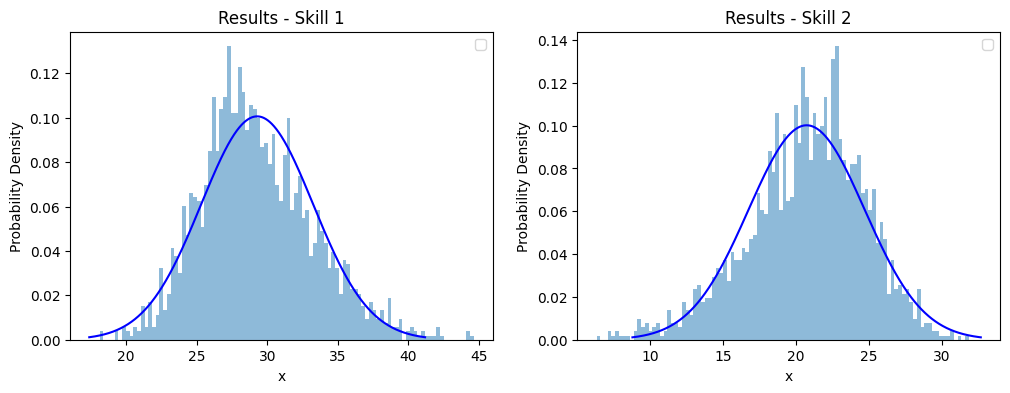

In [3]:
s1 = Skill(25,25/3)
s2 = Skill(25,25/3)


# Record the start time
start_time = time.time()


#sample
result_gibb = Gibbs_sampling(s1, s2, sample_size=2000)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

skill1_sample = result_gibb[:,0]
skill2_sample = result_gibb[:,1]


plt.figure(figsize=(12, 4))

#approximate the gaussian
result1 = gaussian_approximation(skill1_sample)
result2= gaussian_approximation(skill2_sample)
x1 = result1[0]
y1 = result1[1]

x2 = result2[0]
y2 = result2[1]

#plot

plt.subplot(1, 2, 1)
plt.hist(skill1_sample, bins=100, density=True, alpha=0.5)
plt.plot(x1, y1, color="blue")
plt.title('Results - Skill 1')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Subplot 2: Second Normal Distribution
plt.subplot(1, 2, 2)
plt.hist(skill2_sample, bins=100, density=True, alpha=0.5)
plt.plot(x2, y2, color="blue")
plt.title('Results - Skill 2')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

#plt.savefig('gibbs_1000samples.png')
plt.show()

## Q4

In [4]:
s1 = Skill(0,1)
s2 = Skill(0,1)
print('Sample size 5000 | Burn-in 100')
print("Prior mean s1", s1.mean, "Prior variance s1", s1.var)
print("Prior mean s2", s2.mean, "Prior variance s2", s2.var)
samples = Gibbs_sampling(s1,s2, sample_size=5000)
print('Sample size 5000 | Burn-in 100')
print("Posterior mean s1:", np.round(np.mean(samples[:,0])), "Posterior variance s1:", np.round(np.var([samples[:,0]])))
print("Posterior mean s2:", np.round(np.mean(samples[:,1])), "Posterior variance s2:", np.round(np.var([samples[:,1]])))

Sample size 5000 | Burn-in 100
Prior mean s1 0 Prior variance s1 1
Prior mean s2 0 Prior variance s2 1
Sample size 5000 | Burn-in 100
Posterior mean s1: 1.0 Posterior variance s1: 1.0
Posterior mean s2: -1.0 Posterior variance s2: 1.0


In [5]:
s1 = Skill(0,1)
s2 = Skill(0,1)

result_gibb = Gibbs_sampling(s1, s2, sample_size=500, burn_in =0)

skill1_sample = result_gibb[:,0]
skill2_sample = result_gibb[:,1]

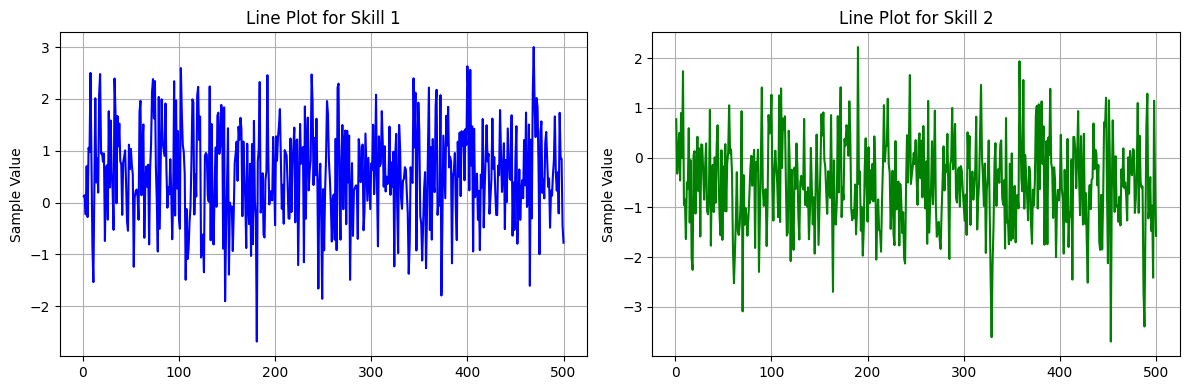

In [6]:
iterations = range(1, len(skill1_sample) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first set of samples
axes[0].plot(iterations, skill1_sample, linestyle='-', color='b')
axes[0].set_ylabel('Sample Value')
axes[0].set_title('Line Plot for Skill 1')
axes[0].grid(True)

# Plot the second set of samples
axes[1].plot(iterations, skill2_sample, linestyle='-', color='g')
axes[1].set_ylabel('Sample Value')
axes[1].set_title('Line Plot for Skill 2')
axes[1].grid(True)

# Adjust layout and display the subplots
plt.tight_layout()

plt.savefig('Gibbs_sampling.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Elapsed time: 0.38590240478515625 seconds
0.5353750879466634
0.9622644952467688
-0.6213875887551349
0.9835756245060173


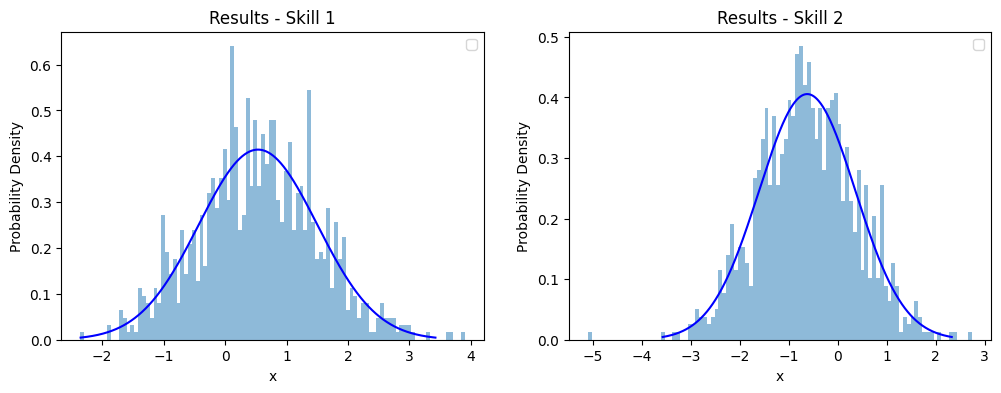

In [7]:
## second plot 
import time


# Record the start time
start_time = time.time()


#sample
result_gibb = Gibbs_sampling(s1, s2, sample_size=1000)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

skill1_sample = result_gibb[:,0]
skill2_sample = result_gibb[:,1]


plt.figure(figsize=(12, 4))

#approximate the gaussian
result1 = gaussian_approximation(skill1_sample)
result2= gaussian_approximation(skill2_sample)
x1 = result1[0]
y1 = result1[1]

x2 = result2[0]
y2 = result2[1]

#plot

plt.subplot(1, 2, 1)
plt.hist(skill1_sample, bins=100, density=True, alpha=0.5)
plt.plot(x1, y1, color="blue")
plt.title('Results - Skill 1')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Subplot 2: Second Normal Distribution
plt.subplot(1, 2, 2)
plt.hist(skill2_sample, bins=100, density=True, alpha=0.5)
plt.plot(x2, y2, color="blue")
plt.title('Results - Skill 2')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

plt.savefig('gibbs_1000samples.png')
plt.show()

## Q5

In [42]:
# Read data from matches in Serie A
serieA = pd.read_csv("data/serieA.csv")

### DATA PREPROCESSING

# Remove tied games
serieA = serieA.drop(serieA[serieA["score1"] == serieA["score2"]].index) 

# Shuffle rows
serieAShuffled = serieA.sample(frac = 1)

# Check for unique teams in the table
unique1 = serieA.team1.unique().tolist()
unique2 = serieA.team2.unique().tolist()
unique = list(set(unique1+unique2))

In [9]:
# Create dict of all teams and their parameters(mean and variance of their skill)
teams = {}
for team in unique:
    teams[team] = Skill(0,1) # Initial mean and variance is 0 and 1 respectively

In [10]:
# Iterate over each match in order and update each teams parameters
# Arguments is a dictionary of all team's mean and variance  &  a pandas dataframe with games
def simulate(teams, serieA):
    for index, row in serieA.iterrows():
        team1 = row["team1"]
        team2 = row["team2"]
        outcome = row["score1"] - row["score2"]
        if(outcome > 0):
            outcome = 1 # sign(outcome) > 0 means that team 1 won, set outcome to 1
            parametersTeam1 = teams.get(team1) # Get mean and variance of team 1
            parametersTeam2 = teams.get(team2) # Get mean and variance of team 2
            # Use gibbs to sample from both teams parameters and outcome of game
            samples = Gibbs_sampling_2(mu_s1 = parametersTeam1[0], sigma_s1 = parametersTeam1[1], mu_s2 = parametersTeam2[0], sigma_s2 = parametersTeam2[1], t = outcome)
            # Get samples from both team
            sampleTeam1 = samples[:,0]
            sampleTeam2 = samples[:,1]
        else:
            outcome = 1 # sign(outcome) < 0 means that team 2 won, set outcome to 1 but let team 2 be sent in as team 1 in gibbs
            parametersTeam1 = teams.get(team1) # Get mean and variance of team 1
            parametersTeam2 = teams.get(team2) # Get mean and variance of team 2
            # Use gibbs to sample from both teams parameters and outcome of game
            samples = Gibbs_sampling_2(mu_s1 = parametersTeam2[0], sigma_s1 = parametersTeam2[1], mu_s2 = parametersTeam1[0], sigma_s2 = parametersTeam1[1], t = outcome)
            # Get samples from both team
            sampleTeam2 = samples[:,0] # Reversed order, team2 is the first list of samples from gibbs
            sampleTeam1 = samples[:,1] # Reversed order, team1 is the second list of samples from gibbs
            
        # Calculate new mean and variance for team 1 and team 2
        mean1 = statistics.mean(sampleTeam1) # Mean of team 1 samples
        variance1 = statistics.variance(sampleTeam1) # Variance of team 1 samples
        mean2 = statistics.mean(sampleTeam2) # Mean of team 2 samples
        variance2 = statistics.variance(sampleTeam2) # of team 2 samples
        # Update parameter dict "teams" with new mean and variance for the two teams
        teams.update({team1:[mean1, variance1],team2:[mean2, variance2]}) 
        
    return teams

In [11]:
# Create dict of all teams and their parameters(mean and variance of their skill)
teams = {}
for team in unique:
    teams[team] = [0,1] # Initial mean and variance is 0 and 1 respectively
teams = simulate(teams, serieA) # Calling function with teams dict and serieA dataframe
# List of all team with parameters
meanList = []
for team in teams:
    meanList.append((teams[team][0], teams[team][1], team))

# Print team(mean, standard deviation) in order
meanList.sort(reverse = True)
for team in meanList:
    print((team[2], np.around(team[0],3), np.around(np.sqrt(team[1]),3))) # Square root the variance to get standard deviation

('Juventus', 0.422, 0.104)
('Milan', 0.342, 0.094)
('Atalanta', 0.324, 0.096)
('Napoli', 0.321, 0.088)
('Inter', 0.307, 0.092)
('Roma', 0.26, 0.096)
('Torino', 0.136, 0.084)
('Spal', 0.076, 0.079)
('Sampdoria', 0.039, 0.075)
('Bologna', 0.036, 0.079)
('Lazio', -0.009, 0.075)
('Genoa', -0.025, 0.125)
('Empoli', -0.062, 0.076)
('Udinese', -0.09, 0.081)
('Cagliari', -0.103, 0.079)
('Parma', -0.154, 0.101)
('Fiorentina', -0.246, 0.11)
('Sassuolo', -0.269, 0.129)
('Frosinone', -0.437, 0.101)
('Chievo', -0.946, 0.121)


In [12]:
# Create dict of all teams and their parameters(mean and variance of their skill)
teams = {}
for team in unique:
    teams[team] = [0,1] # Initial mean and variance is 0 and 1 respectively
teams = simulate(teams, serieAShuffled) # Calling function with teams dict and serieAShuffled dataframe

# List of all team with parameters
meanList = []
for team in teams:
    meanList.append((teams[team][0], teams[team][1], team))

# Print team(mean,variance) in order
meanList.sort(reverse = True)
for team in meanList:
    print((team[2], np.around(team[0],3), np.around(np.sqrt(team[1]),3))) # Square root the variance to get standard deviation 

('Juventus', 0.955, 0.111)
('Torino', 0.445, 0.144)
('Milan', 0.377, 0.074)
('Lazio', 0.358, 0.089)
('Napoli', 0.341, 0.104)
('Inter', 0.31, 0.096)
('Atalanta', 0.231, 0.071)
('Roma', 0.219, 0.074)
('Sampdoria', 0.17, 0.069)
('Bologna', 0.132, 0.082)
('Spal', 0.095, 0.076)
('Sassuolo', 0.06, 0.112)
('Fiorentina', -0.009, 0.086)
('Udinese', -0.017, 0.062)
('Cagliari', -0.03, 0.093)
('Parma', -0.033, 0.067)
('Genoa', -0.053, 0.078)
('Empoli', -0.116, 0.098)
('Frosinone', -0.29, 0.124)
('Chievo', -1.231, 0.129)


## Q6

In [43]:
# Read data
serieA = pd.read_csv("data/serieA.csv")
# Remove tied games
serieA = serieA.drop(serieA[serieA["score1"] == serieA["score2"]].index) 


In [14]:
# Create dict of all teams and their parameters(mean and variance of their skill)
teams = {}
for team in unique:
    teams[team] = [0,1] # Initial mean and variance is 0 and 1 respectively
teams = simulate(teams, serieA) # Calling function with teams dict and serieA dataframe
# List of all team with parameters
meanList = []
for team in teams:
    meanList.append((teams[team][0], teams[team][1], team))

# Print team(mean, standard deviation) in order
meanList.sort(reverse = True)
for team in meanList:
    print((team[2], np.around(team[0],3), np.around(np.sqrt(team[1]),3))) # Square root the variance to get standard deviation

('Juventus', 0.559, 0.115)
('Napoli', 0.468, 0.098)
('Milan', 0.416, 0.1)
('Atalanta', 0.396, 0.106)
('Inter', 0.38, 0.104)
('Roma', 0.367, 0.114)
('Torino', 0.279, 0.098)
('Spal', 0.193, 0.087)
('Sampdoria', 0.153, 0.086)
('Bologna', 0.135, 0.087)
('Genoa', 0.127, 0.121)
('Lazio', 0.088, 0.081)
('Empoli', 0.079, 0.087)
('Udinese', 0.035, 0.098)
('Cagliari', -0.075, 0.094)
('Parma', -0.17, 0.121)
('Sassuolo', -0.205, 0.137)
('Fiorentina', -0.207, 0.117)
('Frosinone', -0.426, 0.125)
('Chievo', -0.933, 0.145)


In [15]:
x = [] # List of x values to insert into bayesian model(The difference in skill of the two teams in each game)
for index, row in serieA.iterrows(): # Iterate over all games
    x.append(teams[row["team1"]][0] - teams[row["team2"]][0]) # Difference in mean skill of the two teams    

In [16]:
# Add output column y, 1 if team 1 won and -1 if team 2 won
y = [] # Keep track of all y's
for index, row in serieA.iterrows():
    if((row["score1"] - row["score2"]) > 0): # outcome > 0 means team 1 won
        y.append(1)
    else: # team 2 won
        y.append(-1)
     

In [17]:
nFeatures = 2 # Number of features
# Define the feature vector
def Phi(a):  # Phi(a) = [1, a]
    return np.power(np.reshape(a, (-1, 1)), range(2))
beta = 2**(-2) # measurement noise precision
mu0 = np.zeros(nFeatures) # Mean vector
sigma0 = np.eye(nFeatures) # Covariance Matrix

In [18]:
seed = 100 # Random seed(Should be determinsitic, keep constant)
samples = 1 # Samples of w
predictions = [] # List of predictions
i = 0 # Keep track of current row number
for _ , row in serieA.iterrows(): # Iterate over each game
    xn = x[0:i] # Only allowed to use the information of previous matches in this prediction
    yn = y[0:i] # Only allowed to use the information of previous matches in this prediction
    if(i != 0): # First game means you can't use any information
        SN = np.linalg.inv(np.linalg.inv(sigma0) + beta * Phi(xn).T @ Phi(xn))
        mN = SN @ (np.linalg.inv(sigma0) @ mu0 + beta * Phi(xn).T @ yn)
        
        ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed) # get w

        # Compute prediction for current game
        prediction = Phi(x[i]) @ ws.T # Get the prediction of current match: x[i] is the difference in skill for current match
        if(prediction > 0):
            predictions.append(1)
        else:
            predictions.append(-1)
    else: # The first game where no prior game can be used
        if(x[0] > 0): # Guess that the team with higest mean skill estimate wins
            predictions.append(1)
        else:
            predictions.append(-1)
    
    i += 1      

In [19]:
correctGuesses = 0 # Keep track of how many correct guesses the model does
for pred, outcome in zip(predictions, y): # Iterate over each game with (prediction, actual outcome)
    if(pred == outcome): # Prediction and actual outcome the same
        correctGuesses += 1
        
predictionRate = correctGuesses/len(predictions) # Calculate prediction rate: (correct guesses/ number of total guesses) 
predictionRate

0.6360294117647058

## Q8

1.5499555964294454
0.9583749910691767
0.4338739579944684
0.9572408877747975


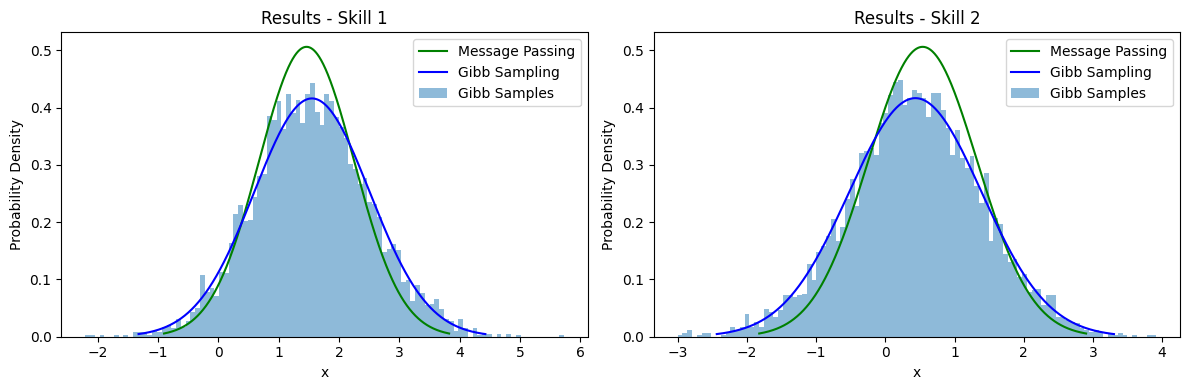

In [20]:
#i think we have changed values since then !!!

s1 = Skill(1,1)
s2 = Skill(1,1)

message_passing(s1,s2,y=1)
mean1 = s1.mean
st1 = s1.var

mean2 = s2.mean
st2 = s2.var


x1 = np.linspace(mean1 - 3 * st1, mean1 + 3 * st1, 1000)
y1 = (1 / (st1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x1 - mean1) / st1) ** 2)


# Generate data points for the second normal distribution
x2 = np.linspace(mean2 - 3 * st2, mean2 + 3 * st2, 1000)
y2 = (1 / (st2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x2 - mean2) / st2) ** 2)

s1 = Skill(1,1)
s2 = Skill(1,1)
result_gibb = Gibbs_sampling(s1, s2, sample_size=5000)


skill1_sample = result_gibb[:,0]
skill2_sample = result_gibb[:,1]


plt.figure(figsize=(12, 4))

#approximate the gaussian
result1 = gaussian_approximation(skill1_sample)
result2= gaussian_approximation(skill2_sample)
x1_samples = result1[0]
y1_samples = result1[1]

x2_samples = result2[0]
y2_samples = result2[1]

#plot

# Subplot 1: First Normal Distribution
plt.subplot(1, 2, 1)
plt.plot(x1, y1, color="green",label="Message Passing")
plt.plot(x1_samples, y1_samples, color="blue", label="Gibb Sampling")
plt.hist(skill1_sample, bins=100, density=True, alpha=0.5, label='Gibb Samples')
plt.title('Results - Skill 1')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Subplot 2: Second Normal Distribution
plt.subplot(1, 2, 2)
plt.plot(x2, y2, color="green",label="Message Passing")
plt.plot(x2_samples, y2_samples, color="blue", label="Gibb Sampling")
plt.hist(skill2_sample, bins=100, density=True, alpha=0.5, label='Gibb Samples')
plt.title('Results - Skill 2')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()

plt.savefig('message_and_gibb.png')
plt.show()

## Q.9

In [44]:
# Pre-process data
matchinfo = pd.read_csv("data/matchinfo.csv")
lol_data = pd.read_csv("data/leagueoflegends.csv")
match_2015 = matchinfo[matchinfo['Year']==2015]
match_selection = match_2015[match_2015['League'] == 'NALCS']
spring_season = match_selection[match_selection['Season'] == 'Spring']
summer_season = match_selection[match_selection['Season'] == 'Summer']
unique1 = match_selection.blueTeamTag.unique().tolist()
unique2 = match_selection.redTeamTag.unique().tolist()
unique3 = list(set(unique1+unique2))

In [22]:
teams = {}
for team in unique3:
    teams[team] = Skill(0,1)

In [23]:
### Simulate using spring season data
get_posterior(teams, match_selection)
sorted_teams = sorted(teams.items(), key=lambda x: x[1].mean, reverse=True)

for team in sorted_teams:
    print(team[0], np.round(team[1].mean,2), np.round(team[1].var,2))

CLG 0.64 0.04
CA 0.6 0.12
TSM 0.57 0.04
EG 0.43 0.64
TL 0.43 0.03
TIP 0.33 0.03
C9 0.29 0.03
GV 0.22 0.04
FSN 0.02 0.08
DIG -0.09 0.04
F5 -0.12 0.16
MKZ -0.25 0.5
COW -0.25 0.35
CST -0.26 0.07
T8 -0.27 0.05
COL -0.4 0.27
CLB -0.52 0.69
TDK -0.54 0.1
WFX -0.56 0.09
NME -0.68 0.1
ZEN -0.69 0.67
FIS -0.69 0.67
PRO -0.7 0.36
NTR -1.16 0.5
CG -1.5 0.48


### Predict the data

In [24]:
x = [] # List of x values to insert into bayesian model(The difference in skill of the two teams in each game)
for index, row in match_selection.iterrows(): # Iterate over all games
    x.append(teams[row["blueTeamTag"]].mean - teams[row["redTeamTag"]].mean) # Difference in mean skill of the two teams    

In [25]:
y = [] # Keep track of all y's
for index, row in match_selection.iterrows():
    if((row["bResult"] - row["rResult"]) > 0): # outcome > 0 means team 1 won
        y.append(1)
    else: # team 2 won
        y.append(-1)

In [26]:
seed = 100 # Random seed(Should be determinsitic, keep constant)
samples = 1 # Samples of w
predictions = [] # List of predictions
i = 0 # Keep track of current row number
for _ , row in match_selection.iterrows(): # Iterate over each game
    xn = x[0:i] # Only allowed to use the information of previous matches in this prediction
    yn = y[0:i] # Only allowed to use the information of previous matches in this prediction
    if(i != 0): # First game means you can't use any information
        SN = np.linalg.inv(np.linalg.inv(sigma0) + beta * Phi(xn).T @ Phi(xn))
        mN = SN @ (np.linalg.inv(sigma0) @ mu0 + beta * Phi(xn).T @ yn)
        
        ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed) # get w
        # Compute prediction for current game
        prediction = Phi(x[i]) @ ws.T # Get the prediction of current match: x[i] is the difference in skill for current match
        if(np.mean(prediction) > 0):
            predictions.append(1)
        else:
            predictions.append(-1)
    else: # The first game where no prior game can be used
        if(x[0] > 0): # Guess that the team with higest mean skill estimate wins
            predictions.append(1)
        else:
            predictions.append(-1)
    
    i += 1  


In [27]:
correctGuesses = 0 # Keep track of how many correct guesses the model does
for pred, outcome in zip(predictions, y): # Iterate over each game with (prediction, actual outcome)
    if(pred == outcome): # Prediction and actual outcome the same
        correctGuesses += 1
        
predictionRate = correctGuesses/len(predictions) # Calculate prediction rate: (correct guesses/ number of total guesses) 
print("Prediction rate without modiyfiny anything:",predictionRate)

Prediction rate without modiyfiny anything: 0.5635179153094463


## Q.10 Gibbs sampling BLR

In [28]:
#for now matchinfo enough

#select league (we can change which one) --> should we take one year
match_2018 = matchinfo[matchinfo['Year']==2015]
match_selection = match_2018[match_2018['League'] == 'NALCS']
#match_selection = match_selection[match_selection['Year'] == '2015']


match_spring = match_selection[match_selection['Season']=='Spring']
match_summer = match_selection[match_selection['Season']=='Summer']

shuffled_matches = match_selection.sample(frac = 1) # Shuffled games
unique1 = match_selection.blueTeamTag.unique().tolist()
unique2 = match_selection.redTeamTag.unique().tolist()
unique = list(set(unique1+unique2))

In [29]:
# Create dict of all teams and their parameters(mean and variance of their skill)
teams = {}
for team in unique:
    teams[team] = [0,1] # Initial mean and variance is 0 and 1 respectively
teams = simulate_lol(teams, spring_season) # Calling function with teams dict and serieA dataframe
# List of all team with parameters
meanList = []
for team in teams:
    meanList.append((teams[team][0], teams[team][1], team))

# Print team(mean, standard deviation) in order
meanList.sort(reverse = True)
for team in meanList:
    print((team[2], np.around(team[0],3), np.around(np.sqrt(team[1]),3))) # Square root the variance to get standard deviation

0.29028868675231934
0.27666139602661133
0.28519701957702637
0.2856872081756592
0.28001856803894043
0.2806408405303955
0.27811741828918457
0.2757401466369629
0.29988646507263184
0.2775447368621826
0.28136706352233887
0.284531831741333
0.28763532638549805
0.3079829216003418
0.2723572254180908
0.27031564712524414
0.26659560203552246
0.27854013442993164
0.27845001220703125
0.2926638126373291
0.29300498962402344
0.2753570079803467
0.2823350429534912
0.28607940673828125
0.2777259349822998
0.27103614807128906
0.2976536750793457
0.3042287826538086
0.28790855407714844
0.29509639739990234
0.2798945903778076
0.2693934440612793
0.2741243839263916
0.27240729331970215
0.27362918853759766
0.3021104335784912
0.2866513729095459
0.2730598449707031
0.3085968494415283
0.2667238712310791
0.27289295196533203
0.28635334968566895
0.26903438568115234
0.2650644779205322
0.29410529136657715
0.3098444938659668
0.26874256134033203
0.2943253517150879
0.2642652988433838
0.29642534255981445
0.2850360870361328
0.29220

In [30]:
x = [] # List of x values to insert into bayesian model(The difference in skill of the two teams in each game)
for index, row in spring_season.iterrows(): # Iterate over all games
    x.append(teams[row["blueTeamTag"]][0] - teams[row["redTeamTag"]][0]) # Difference in mean skill of the two teams

In [31]:
# Add output column y, 1 if team 1 won and -1 if team 2 won
y = [] # Keep track of all y's
for index, row in match_spring.iterrows():
    if(row["bResult"] == 1): # means blue team won
        y.append(1)
    else: # red team won
        y.append(-1)

In [32]:
nFeatures = 2 # Number of features
# Define the feature vector
def Phi(a):  # Phi(a) = [1, a]
    return np.power(np.reshape(a, (-1, 1)), range(2))
beta = 2**(-2) # measurement noise precision
mu0 = np.zeros(nFeatures) # Mean vector
sigma0 = np.eye(nFeatures) # Covariance Matrix

In [33]:
xSummer = [] # List of x values to insert into bayesian model(The difference in skill of the two teams in each game)
for index, row in summer_season.iterrows(): # Iterate over all games
    xSummer.append(teams[row["blueTeamTag"]][0] - teams[row["redTeamTag"]][0]) # Difference in mean skill of the two teams

In [34]:
# Add output column y, 1 if team 1 won and -1 if team 2 won
ySummer = [] # Keep track of all y's
for index, row in summer_season.iterrows():
    if(row["bResult"] == 1): # means blue team won
        ySummer.append(1)
    else: # red team won
        ySummer.append(-1)

In [35]:
predictions, w = BLR_Gibbs(x,y, xSummer)
correctGuesses = 0 # Keep track of how many correct guesses the model does
for pred, outcome in zip(predictions, ySummer): # Iterate over each game with (prediction, actual outcome)
    if(pred == outcome): # Prediction and actual outcome the same
        correctGuesses += 1
        
predictionRate = correctGuesses/len(predictions) # Calculate prediction rate: (correct guesses/ number of total guesses) 
predictionRate

0.5985401459854015

## BLR Belief Propagation

In [36]:
# Initialize teams
teams = {}
for team in unique3:
    teams[team] = Skill(0,1)
get_posterior(teams,spring_season)
x_spring = []
x_summer = []
for index, row in spring_season.iterrows(): # Iterate over all games
    x_spring.append(teams[row["blueTeamTag"]].mean - teams[row["redTeamTag"]].mean)
for index, row in summer_season.iterrows(): # Iterate over all games
    x_summer.append(teams[row["blueTeamTag"]].mean - teams[row["redTeamTag"]].mean)

# Add output column y, 1 if team 1 won and -1 if team 2 won
y = [] # Keep track of all y's
for index, row in spring_season.iterrows():
    if(row["bResult"] == 1): # means blue team won
        y.append(1)
    else: # red team won
        y.append(-1)
# Add output column y, 1 if team 1 won and -1 if team 2 won
ySummer = [] # Keep track of all y's
for index, row in summer_season.iterrows():
    if(row["bResult"] == 1): # means blue team won
        ySummer.append(1)
    else: # red team won
        ySummer.append(-1)

In [37]:
predictions, w_without_prior = BLR_MP(x_spring, y, x_summer)

In [38]:
correctGuesses = 0 # Keep track of how many correct guesses the model does
for pred, outcome in zip(predictions, ySummer): # Iterate over each game with (prediction, actual outcome)
    if(pred == outcome): # Prediction and actual outcome the same
        correctGuesses += 1
        
predictionRate = correctGuesses/len(predictions) # Calculate prediction rate: (correct guesses/ number of total guesses) 
print("Prediction rate without adding prior knowledge", np.round(predictionRate,3))

Prediction rate without adding prior knowledge 0.569


In [39]:
# Initialize teams
teams = {}
for team in unique3:
    teams[team] = Skill(0,1)
get_posterior_adapted(teams,spring_season)
x_spring = []
x_summer = []
for index, row in spring_season.iterrows(): # Iterate over all games
    x_spring.append(teams[row["blueTeamTag"]].mean - teams[row["redTeamTag"]].mean)
for index, row in summer_season.iterrows(): # Iterate over all games
    x_summer.append(teams[row["blueTeamTag"]].mean - teams[row["redTeamTag"]].mean)

# Add output column y, 1 if team 1 won and -1 if team 2 won
y = [] # Keep track of all y's
for index, row in spring_season.iterrows():
    if(row["bResult"] == 1): # means blue team won
        y.append(1)
    else: # red team won
        y.append(-1)
# Add output column y, 1 if team 1 won and -1 if team 2 won
ySummer = [] # Keep track of all y's
for index, row in summer_season.iterrows():
    if(row["bResult"] == 1): # means blue team won
        ySummer.append(1)
    else: # red team won
        ySummer.append(-1)

In [40]:
predictions_w_prior, w_with_prior = BLR_MP(x_spring, y, x_summer)

In [41]:
correctGuesses = 0 # Keep track of how many correct guesses the model does
for pred, outcome in zip(predictions_w_prior, ySummer): # Iterate over each game with (prediction, actual outcome)
    if(pred == outcome): # Prediction and actual outcome the same
        correctGuesses += 1
        
predictionRate = correctGuesses/len(predictions_w_prior) # Calculate prediction rate: (correct guesses/ number of total guesses) 
print("Prediction rate with adding prior knowledge", np.round(predictionRate,3))

Prediction rate with adding prior knowledge 0.613
